# Mobile Application Marketing (Part III)


# Analyzing Organic Revenue Prediction Alteranatives

In [1]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2023-09-08 18:17:47.675970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
data = pd.read_csv('data/sample_data_2_ofuscated.csv')
data_cleaned = data.dropna()

# Convert 'date' column to datetime format
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])

# Create a numeric 'days_since_start' column
data_cleaned['days_since_start'] = (data_cleaned['date'] - data_cleaned['date'].min()).dt.days

# Store dates before dropping from data_cleaned
dates = data_cleaned['date']

# Drop the original 'date' column
data_cleaned = data_cleaned.drop(columns=['date'])

# Encode the categorical variables
for column in ['sku', 'network_name', 'region']:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])

# Split data into train and test sets and remember the indices
X = data_cleaned[['sku', 'network_name', 'region', 'days_since_start','spend','d0_paid_revenue', 'd0_organic_revenue','d7_paid_revenue','d7_organic_revenue']]
y = data_cleaned['d360_organic_revenue']
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data_cleaned.index, test_size=0.2, random_state=42)

# Scale the features using MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model structure
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Adding dropout with 50% probability
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adding another dropout layer
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Adjusting learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

# Set early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Mean Absolute Error (MAE): {test_mae}")

/var/folders/cc/psdqzrt5743dsmcrz03hh4zw0000gn/T/ipykernel_74982/1201969329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])
/var/folders/cc/psdqzrt5743dsmcrz03hh4zw0000gn/T/ipykernel_74982/1201969329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['days_since_start'] = (data_cleaned['date'] - data_cleaned['date'].min()).dt.days


Epoch 1/300
143/162 [=========================>....] - ETA: 0s - loss: 59939.9453 - mae: 93.8942 
Epoch 1: val_loss improved from inf to 7281.94141, saving model to best_model.h5
162/162 [==============================] - 1s 3ms/step - loss: 54835.8359 - mae: 88.5660 - val_loss: 7281.9414 - val_mae: 35.9388
Epoch 2/300
 88/162 [===============>..............] - ETA: 0s - loss: 10889.0088 - mae: 39.7193

/Users/memozac/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/162 [=======================>......] - ETA: 0s - loss: 10128.5547 - mae: 38.0831
Epoch 2: val_loss improved from 7281.94141 to 6321.02002, saving model to best_model.h5
162/162 [==============================] - 0s 2ms/step - loss: 10027.9551 - mae: 38.3024 - val_loss: 6321.0200 - val_mae: 29.5321
Epoch 3/300
136/162 [========================>.....] - ETA: 0s - loss: 9556.9238 - mae: 36.1699
Epoch 3: val_loss improved from 6321.02002 to 5905.41309, saving model to best_model.h5
162/162 [==============================] - 0s 2ms/step - loss: 9875.7217 - mae: 36.0031 - val_loss: 5905.4131 - val_mae: 27.0547
Epoch 4/300
136/162 [========================>.....] - ETA: 0s - loss: 8922.7148 - mae: 34.3598
Epoch 4: val_loss improved from 5905.41309 to 5894.88574, saving model to best_model.h5
162/162 [==============================] - 0s 2ms/step - loss: 8383.1104 - mae: 33.5172 - val_loss: 5894.8857 - val_mae: 25.9693
Epoch 5/300
134/162 [=======================>......] - ETA: 0s - loss: 

In [3]:
# Predict
predicted_values = model.predict(X_test_scaled)

# Create a DataFrame from predicted values
predicted_values_df = pd.DataFrame(predicted_values, columns=['predicted_values'])
predicted_values_df['actual_values'] = y_test.values

# Add the categorical columns and date to the predicted_values_df
predicted_values_df['sku'] = X_test['sku'].values
predicted_values_df['network_name'] = X_test['network_name'].values
predicted_values_df['region'] = X_test['region'].values
predicted_values_df['date'] = dates[idx_test].values

# Reset the index for better visual representation
predicted_values_df.reset_index(drop=True, inplace=True)
predicted_values_df.head()


101/101 [==============================] - 0s 669us/step


,predicted_values,actual_values,sku,network_name,region,date
0,4.274690,4.649950,0,2,0,2021-09-17
1,2.738095,0.010660,0,5,3,2020-07-02
2,3.136326,4.972345,0,1,0,2020-07-23
3,115.771149,133.923853,0,2,1,2020-08-22
4,24.735744,62.466990,0,0,1,2020-04-04


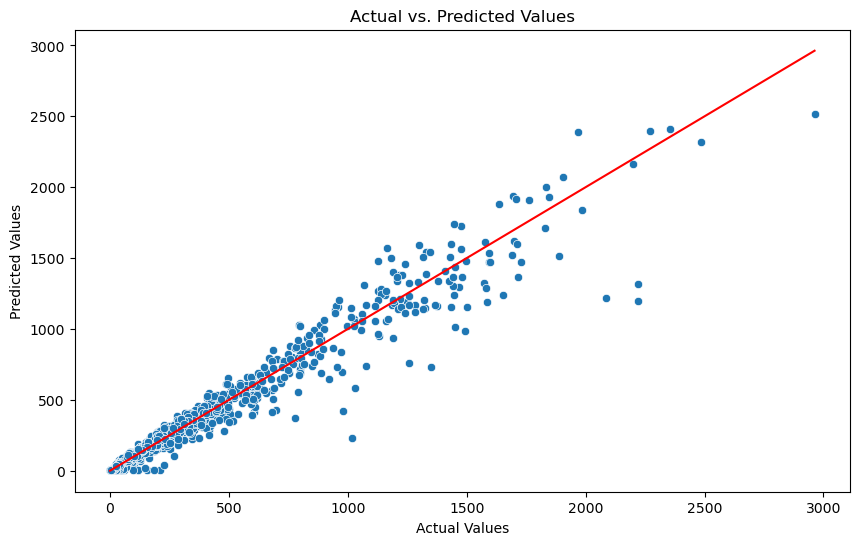

In [4]:
# Scatter plot to compare actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_values', y='predicted_values', data=predicted_values_df)
plt.plot([min(predicted_values_df['actual_values']), max(predicted_values_df['actual_values'])], 
         [min(predicted_values_df['actual_values']), max(predicted_values_df['actual_values'])], 
         color='red')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [5]:
# sum predicted values by date
plot_df = predicted_values_df[['date', 'predicted_values', 'actual_values']].groupby('date').sum().reset_index()
plot_df.head()

,date,predicted_values,actual_values
0,2020-04-02,3.120594,0.00000
1,2020-04-03,56.715973,64.96849
2,2020-04-04,27.859270,62.48699
3,2020-04-05,2.959856,0.31591
4,2020-04-07,2.907242,0.03000


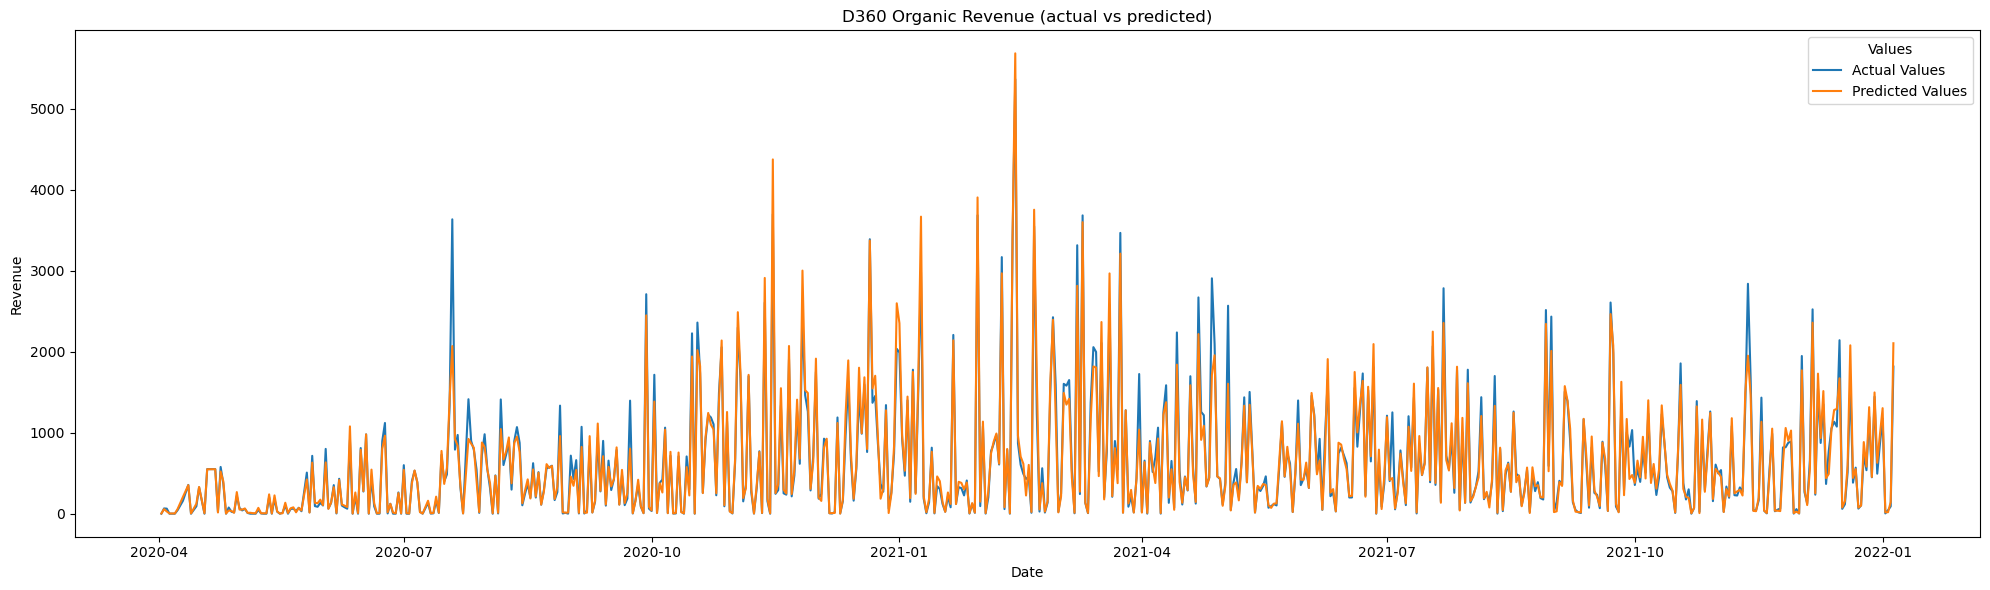

In [10]:
# Create a line plot using seaborn
plt.figure(figsize=(20, 6))
sns.lineplot(data=plot_df, x='date', y='actual_values')
sns.lineplot(data=plot_df, x='date', y='predicted_values')
plt.title('D360 Organic Revenue (actual vs predicted)')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend(title='Values', labels=['Actual Values', 'Predicted Values'])
plt.tight_layout()
plt.show()
